In [1]:
# # !!! only uncomment and run when using colab !!!
import os
os.chdir("/content")
! pwd
isExist = os.path.exists("UQpresentation")
if not isExist:
  os.mkdir("UQpresentation")
os.chdir("UQpresentation") 
!pwd
! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
!ls
os.chdir("/content/UQpresentation/CPlantBox/")
! git checkout UQpresentation # switch to the branch with the presentation
! git pull #get latest version 
! cmake . #build
! make
os.chdir("/content/UQpresentation/CPlantBox/tutorial/jupyter/UQ_15_08_2022/") #go to correct directory

# UQ presentation - 2022 - coupled carbon and water flow in CPlantBox

## Simulation of water and carbon movement 


In the following we will show how to compute the couple water and carbo flow in the plant. 



We consider dynamic plant and a static soil. 
To compute the water xylem flux we use the hybrid analytical approach of Meunier et al. (2017). To compute the photosynthesis rate, we use the Leuning methode, as presented by Tuzet et al. (2003). To compute the carbon flux, we use the code developped by Lacointe et al. (2019).

**Reference**

F Meunier, X Draye, J Vanderborght, M Javaux, V Couvreur. A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures. *Applied Mathematical modelling*, 2017.

A Tuzet, A Perrier, R Leuning. A coupled model of stomatal conductance, photosynthesis and transpiration. *Plant, Cell & Environment*, 2003.

A Lacointe and P. Minchin. A mechanistic model to predict distribution of carbon among multiple sinks. *Methods in molecular biology* (Clifton, N.J.) vol. 2014, 2019.
	

In [1]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
from xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import vtk_plot as vp # for quick 3d vizualisations
import matplotlib.pyplot as plt
from phloem_flux import PhloemFluxPython  


## 1. Define environmental variabes



In [2]:
"""avoid division per 0 during post processing"""
def div0(a, b, c):        
    return np.divide(a, b, out=np.full(len(a), c), where=b!=0)
    
def div0f(a, b, c):    
    if b != 0:
        return a/b
    else:
        return a/c

"""compute soil water potential from water content and VanGenouchten parameters"""
def theta2H(vg,theta):#(-) to cm
    thetar =vg[0] 
    thetas = vg[1] 
    alpha = vg[2] 
    n = vg[3] 
    nrev = 1/(1-1/n)
    H =-(((( (thetas - thetar)/(theta - thetar))**nrev) - 1)**(1/n))/alpha
    return(H)#cm

def sinusoidal(t):
    return (np.sin(np.pi*t*2)+1)/2

"""compute air relative humidity"""
def qair2rh(qair, es_, press):
    e =qair * press / (0.378 * qair + 0.622)
    rh = e / es_
    rh=max(min(rh, 1.),0.)
    return rh

"""get environmental conditions"""
def weather(simDuration):
    vgSoil = [0.059, 0.45, 0.00644, 1.503, 1] #van Gemuchten parameters
    
    Qmin = 0; Qmax = 960e-6 #incoming light
    Tmin = 15.8; Tmax = 22 #temperature
    specificHumidity = 0.0097 #specific air humidity
    Pair = 1010.00 #hPa
    thetaInit = 30/100 #soil water content

    coefhours = sinusoidal(simDuration) #sinusoidal coeficient to get daily variation
    TairC_ = Tmin + (Tmax - Tmin) * coefhours
    Q_ = Qmin + (Qmax - Qmin) * coefhours
    cs = 850e-6 #co2 paartial pressure at leaf surface (mol mol-1)
    es =  6.112 * np.exp((17.67 * TairC_)/(TairC_ + 243.5)) 
    RH = qair2rh(specificHumidity, es, Pair)
    
    pmean = theta2H(vgSoil, thetaInit)
    
    weatherVar = {'TairC' : TairC_,
                    'Qlight': Q_,
                    'cs':cs, 'RH':RH, 'p_mean':pmean, 'vg':vgSoil}
    return weatherVar

## 2. Define xylem and phloem shape

In [3]:

def setKrKx_xylem(TairC, RH): #inC
    #mg/cm3
    hPa2cm = 1.0197
    dEauPure = (999.83952 + TairC * (16.952577 + TairC * 
        (- 0.0079905127 + TairC * (- 0.000046241757 + TairC * 
        (0.00000010584601 + TairC * (- 0.00000000028103006)))))) /  (1 + 0.016887236 * TairC)
    siPhi = (30 - TairC) / (91 + TairC)
    siEnne=0
    mu =  pow(10, (- 0.114 + (siPhi * (1.1 + 43.1 * pow(siEnne, 1.25) )))) 
    mu = mu /(24*60*60)/100/1000; #//mPa s to hPa d, 1.11837e-10 hPa d for pure water at 293.15K
    #water viscosity
    mu = mu * hPa2cm #hPa d to cmh2o d 

    #number of vascular bundles
    VascBundle_leaf = 32
    VascBundle_stem = 52
    VascBundle_root = 1 #valid for all root type
            
    #radius of xylem type^4 * number per bundle
    rad_x_l_1   = (0.0015 **4) * 2; rad_x_l_2   = (0.0005 **4) * 2   
    rad_x_s_1   = (0.0017 **4) * 3; rad_x_s_2   = (0.0008 **4) * 1     
    rad_x_r0_1  = (0.0015 **4) * 4    
    rad_x_r12_1 = (0.00041**4) * 4; rad_x_r12_2 = (0.00087**4) * 1
    rad_x_r3_1  = (0.00068**4) * 1      

    # axial conductivity [cm^3/day]        
    kz_l  = VascBundle_leaf *(rad_x_l_1 + rad_x_l_2)    *np.pi /(mu * 8)  
    kz_s  = VascBundle_stem *(rad_x_s_1 + rad_x_s_2)    *np.pi /(mu * 8) 
    kz_r0 = VascBundle_root * rad_x_r0_1                *np.pi /(mu * 8)  
    kz_r1 = VascBundle_root *(rad_x_r12_1 + rad_x_r12_2)*np.pi /(mu * 8) 
    kz_r2 = VascBundle_root *(rad_x_r12_1 + rad_x_r12_2)*np.pi /(mu * 8)  
    kz_r3 = VascBundle_root * rad_x_r3_1                *np.pi /(mu * 8) # 4.32e-1

    #radial conductivity [1/day],
    kr_l  = 3.83e-4 * hPa2cm# init: 3.83e-4 cm/d/hPa
    kr_s  = 0.#1.e-20  * hPa2cm # set to almost 0
    kr_r0 = 6.37e-5 * hPa2cm 
    kr_r1 = 7.9e-5  * hPa2cm 
    kr_r2 = 7.9e-5  * hPa2cm  
    kr_r3 = 6.8e-5  * hPa2cm 
    l_kr = 0.8 #cm
    r.setKr([[kr_r0,kr_r1,kr_r2,kr_r0],[kr_s,kr_s ],[kr_l]], kr_length_=l_kr) 
    r.setKx([[kz_r0,kz_r1,kz_r2,kz_r0],[kz_s,kz_s ],[kz_l]])
    
    
    Rgaz=8.314 #J K-1 mol-1 = cm^3*MPa/K/mol
    rho_h2o = dEauPure/1000#g/cm3
    Mh2o = 18.05 #g/mol
    MPa2hPa = 10000
    hPa2cm = 1/0.9806806
    #log(-) * (cm^3*MPa/K/mol) * (K) *(g/cm3)/ (g/mol) * (hPa/MPa) * (cm/hPa) =  cm                      
    p_a = np.log(RH) * Rgaz * rho_h2o * (TairC + 273.15)/Mh2o * MPa2hPa * hPa2cm
    
    #air water potential
    r.psi_air = p_a #*MPa2hPa #used only with xylem

    
def setKrKx_phloem(): 

    #number of vascular bundles
    VascBundle_leaf = 32
    VascBundle_stem = 52
    VascBundle_root = 1 #valid for all root type
            
    #number of sieve tubes per bundle
    numL = 18
    numS = 21
    numr0 = 33
    numr1 = 25
    numr2 = 25
    numr3 = 1 

    # axial conductivity [cm^3/day] , mu is added later as it evolves with CST  
    beta = 0.9 #Thompson 2003a
    kz_l   = VascBundle_leaf * numL* (0.00025 **4)   * np.pi /8 * beta  
    kz_s   = VascBundle_stem * numS *(0.00019 **4)    * np.pi /8 * beta
    kz_r0  = VascBundle_root *numr0 *(0.00039 **4)  * np.pi /8 * beta
    kz_r12 = VascBundle_root * numr1*(0.00035**4) * np.pi /8 * beta
    kz_r3  = VascBundle_root * numr3 *(0.00068**4)  * np.pi /8 * beta
    
    
    #radial conductivity [1/day], for carbon exudation
    kr_l  = 0. #always 0 for leaves
    kr_s  = 0. #always 0 for stem
    kr_r0 = 5e-2
    kr_r1 = 5e-2
    kr_r2 = 5e-2
    kr_r3 = 5e-2
    l_kr = 0.8 #cm zone from root tip at which exudation occures
    
    r.setKr_st([[kr_r0,kr_r1 ,kr_r2 ,kr_r0],[kr_s,kr_s ],[kr_l]] , kr_length_= l_kr)
    r.setKx_st([[kz_r0,kz_r12,kz_r12,kz_r0],[kz_s,kz_s ],[kz_l]])
    
    #cross-sectional area, to switch between length and volume
    a_ST = [[0.00039,0.00035,0.00035,0.00039 ],[0.00019,0.00019],[0.00025]]
    Across_s_l   = numL*VascBundle_leaf *(a_ST[2][0]**2)*np.pi
    Across_s_s   = numS *VascBundle_stem * (a_ST[1][0]**2)*np.pi     
    Across_s_r0  = numr0 *VascBundle_root * (a_ST[0][0]**2)*np.pi   
    Across_s_r12 = numr1*VascBundle_root * (a_ST[0][1]**2)*np.pi
    Across_s_r3  =  numr3 *VascBundle_root *(a_ST[0][2]**2)*np.pi   
    r.setAcross_st([[Across_s_r0,Across_s_r12,Across_s_r12,Across_s_r0],[Across_s_s,Across_s_s],[Across_s_l]])

## 3. Define initial conditions

In [34]:

weatherInit = weather(0)
simDuration = 7 # [day] init simtime
simMax = 8
dt =1/24
depth = 60
verbose = False


# plant system 
pl = pb.MappedPlant(seednum = 2) 
path = "../../../modelparameter/plant/"
name = "Triticum_aestivum_adapted_2021"
pl.readParameters(path + name + ".xml")

sdf = pb.SDF_PlantBox(np.Inf, np.Inf, depth )
pl.setGeometry(sdf) # creates soil space to stop roots from growing out of the soil


pl.initialize(verbose )
pl.simulate(simDuration, False)


#for post-processing
Q_in  = 0
Q_out = 0
AnSum = 0
filename = "phloemoutputs.txt" 

Q_Rmbu      = np.array([0.])
Q_Grbu      = np.array([0.])
Q_Exudbu    = np.array([0.])
Q_STbu    = np.array([0.])

Q_Rmall      = np.array([])
Q_Grall      = np.array([])
Q_Exudall    = np.array([])
Growthall    = np.array([])
time = np.array([])
Ntbu = 1

## 4. Define static soil

In [35]:

min_b = [-3./2, -12./2, -61.]#distance between wheat plants
max_b = [3./2, 12./2, 0.]
cell_number = [6, 24, 61] #soil resolution
layers = depth; soilvolume = (depth / layers) * 3 * 12
k_soil = [] #conductivity of soil when in contact with roots
p_mean = weatherInit['p_mean'] #mean soil water potential
p_bot = p_mean + depth/2
p_top = p_mean - depth/2
sx = np.linspace(p_top, p_bot, depth) #soil water potential per voxel

picker = lambda x,y,z : max(int(np.floor(-z)),-1) 
pl.setSoilGrid(picker)  # maps segment


## 5. create object to compute carbon and water flux

In [36]:
#give initial guess of leaf water potential and internal CO2 partial pressure (to start computation loop)
r = PhloemFluxPython(pl,psiXylInit = min(sx),ciInit = weatherInit["cs"]*0.5)


## 6. set other parameters and initial variable

In [37]:
#for photosynthesis
r.g0 = 8e-3              #residual stomatal opening at night 
r.VcmaxrefChl1 =1.28     #influence of leaf chlorophyl content on carboxylation rate
r.VcmaxrefChl2 = 8.33    #influence of leaf chlorophyl content on carboxylation rate
r.a1 = 0.5               #ci/(cs - ci)
r.a3 = 1.5               # VcrefMax to VjrefMax ratio
r.alpha = 0.4            #effect of light on photon flux rate
r.theta = 0.6            #effect of light on photon flux rate
r.cs = weatherInit["cs"] #external CO2 partial rpessure
SPAD= 41.0
chl_ = (0.114 *(SPAD**2)+ 7.39 *SPAD+ 10.6)/10
r.Chl = np.array( [chl_]) #leaf chlorophyle content (mean value or defined per leaf segment)

#for phloem flow
setKrKx_phloem()
r.k_meso = 1e-3 
r.setKrm2([[2e-5]])
r.setKrm1([[10e-2]]) 
r.setRhoSucrose([[0.51],[0.65],[0.56]]) 
r.setRmax_st([[14.4,9.0,6.0,14.4],[5.,5.],[15.]]) 
r.KMfu = 0.1#VERY IMPORTANT TO KEEP IT HIGH
r.sameVolume_meso_st = False
r.sameVolume_meso_seg = True
r.withInitVal =False #no initial concentration of sucrose in the sieve tube
r.beta_loading = 0.6 #feedback effect of sieve tube concentraiton on loading from mesophyll
r.Vmaxloading = 0.05 #mmol/d, max loading rate from mesophyll
r.Mloading = 0.2
r.Gr_Y = 0.8 # efficiency of sucrose usage for growth. if <1, we have growth respiration
r.CSTimin = 0.4 #minimum sucrose concentration below which no sucrose usage occures
r.Csoil = 1e-4 #mean soil concentration in sucrose



r.expression = 6
r.update_viscosity = True #update sucrose viscosity according to concentraiton ?
r.solver = 1 #which solver to use. n# 1 should be the most efficient
r.atol = 1e-12 #max absolute error for sucrose flow solver
r.rtol = 1e-8 #max relative error for sucrose flow solver


## 7. launch simulation

In [38]:

while simDuration <= simMax: 
    
    Nt = len(r.plant.nodes) 
    weatherX = weather(simDuration) #update seather variables
    r.Qlight = weatherX["Qlight"] #
    setKrKx_xylem(weatherX["TairC"], weatherX["RH"]) #update xylem conductivity data
    
    #compute plant water flow
    r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,RH_ = weatherX["RH"],
        verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"] )
    
    
    AnSum += np.sum(r.Ag4Phloem)*dt #total cumulative carbon assimilaiton
    errLeuning = sum(r.outputFlux) #should be 0 : no storage of water in the plant
    fluxes = np.array(r.outputFlux)
    fluxesSoil = r.soilFluxes(simDuration, r.psiXyl, sx, approx=False) #root water flux per soil voxel
    
    
    #simulation of phloem flow
    startphloem= simDuration
    endphloem = startphloem + dt
    stepphloem = 1
    r.startPM(startphloem, endphloem, stepphloem, ( weatherX["TairC"]  +273.15) , True, filename)
        
    #get ouput of sucroes flow computation    
    Q_ST    = np.array(r.Q_out[0:Nt])          #sieve tube sucrose content
    Q_meso  = np.array(r.Q_out[Nt:(Nt*2)])     #mesophyll sucrose content
    Q_Rm    = np.array(r.Q_out[(Nt*2):(Nt*3)]) #sucrose used for maintenance respiration
    Q_Exud  = np.array(r.Q_out[(Nt*3):(Nt*4)]) #sucrose used for exudation
    Q_Gr    = np.array(r.Q_out[(Nt*4):(Nt*5)]) #sucrose used for growth and growth respiration
    
    C_ST    = np.array(r.C_ST)           #sieve tube sucrose concentraiton
    #Fl      = np.array(r.Fl)             #loading rate from mesophyll to sieve tube
    volST   = np.array(r.vol_ST)         #sieve tube volume
    volMeso   = np.array(r.vol_Meso)      #mesophyll volume     
    C_meso  = Q_meso/volMeso              #sucrose concentration in mesophyll
    Q_in   += sum(np.array(r.AgPhl)*dt)  #total sucrose input in the pant
    Q_out   = Q_Rm + Q_Exud + Q_Gr       #total sucrose lost/used by the plant
    error   = sum(Q_ST + Q_meso + Q_out )- Q_in  #balance residual (error)
    
    delta_ls_i = np.array(r.delta_ls_org_i) #organ length increase at last time step
    delta_ls = np.array(r.delta_ls_org) #total organ length increase
    
    #contatn variantion at the last time step
    Q_ST_i        = Q_ST      - Q_STbu 
    Q_Rm_i        = Q_Rm      - Q_Rmbu
    Q_Gr_i        = Q_Gr      - Q_Grbu
    Q_Exud_i      = Q_Exud    - Q_Exudbu
    Q_out_i       = Q_Rm_i    + Q_Exud_i      + Q_Gr_i
    
    #print some outputs
    print("\n\n\n\t\tat ", int(np.floor(simDuration)),"d", int((simDuration%1)*24),"h",  round(r.Qlight *1e6),"mumol m-2 s-1")
    print("Error in Suc_balance:\n\tabs (mmol) {:5.2e}\trel (-) {:5.2e}".format(error, div0f(error,Q_in, 1.)))
    print("Error in photos:\n\tabs (cm3/day) {:5.2e}".format(errLeuning))
    print("water fluxes (cm3/day):\n\ttrans {:5.2e}\tminExud {:5.2e}\tmaxExud {:5.2e}".format(sum(fluxesSoil.values()), min(fluxesSoil.values()), max(fluxesSoil.values())))
    print("assimilated Sucrose (cm)\tAn {:5.2e}".format(AnSum)) 
    print("sucrose concentration in sieve tube (mmol ml-1):\n\tmean {:.2e}\tmin  {:5.2e} at {:d} segs \tmax  {:5.2e}".format(np.mean(C_ST), min(C_ST), len(np.where(C_ST == min(C_ST) )[0]), max(C_ST)))        
    print('cumulatede \tRm   {:.2e}\tGr   {:.2e}\tExud {:5.2e}'.format(sum(Q_Rm), sum(Q_Gr), sum(Q_Exud)))
    print("aggregated sink repartition at last time step (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm_i)/sum(Q_out_i)*100, 
         sum(Q_Gr_i)/sum(Q_out_i)*100,sum(Q_Exud_i)/sum(Q_out_i)*100))
    print("total aggregated sink repartition (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm)/sum(Q_out)*100, 
         sum(Q_Gr)/sum(Q_out)*100,sum(Q_Exud)/sum(Q_out)*100))
    print("growth (cm)\ttot {:5.2e}\ti {:5.2e}".format(sum(delta_ls), sum(delta_ls_i)))      
    
    #plant growth based on Gr
    r.plant.simulate(dt, False)
    simDuration += dt
    
    #for post processing
    Ntbu = Nt
    Nt = len(r.plant.nodes)
    Q_STbu       =   np.concatenate((Q_ST, np.full(Nt - Ntbu, 0.)))
    Q_Rmbu       =   np.concatenate((Q_Rm, np.full(Nt - Ntbu, 0.)))
    Q_Grbu       =   np.concatenate((Q_Gr, np.full(Nt - Ntbu, 0.))) 
    Q_Exudbu     =   np.concatenate((Q_Exud, np.full(Nt - Ntbu, 0.))) 
    
    
    Q_Rmall    = np.append( Q_Rmall  ,sum(Q_Rm_i))
    Q_Grall    = np.append( Q_Grall  ,sum(Q_Gr_i))
    Q_Exudall  = np.append( Q_Exudall,sum(Q_Exud_i))
    Growthall  = np.append( Growthall,sum(delta_ls_i))
    time       = np.append( time ,simDuration)
    





		at  7 d 0 h 480 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) -1.19e-14	rel (-) -8.45e-13
Error in photos:
	abs (cm3/day) -1.92e-10
water fluxes (cm3/day):
	trans -1.56e-02	minExud -5.17e-03	maxExud 0.00e+00
assimilated Sucrose (cm)	An 1.41e-02
sucrose concentration in sieve tube (mmol ml-1):
	mean 3.66e-01	min  3.62e-01 at 1 segs 	max  3.82e-01
cumulatede 	Rm   0.00e+00	Gr   0.00e+00	Exud 0.00e+00
aggregated sink repartition at last time step (%) :
	Rm     nan	Gr     nan	Exud   nan
total aggregated sink repartition (%) :
	Rm     nan	Gr     nan	Exud   nan
growth (cm)	tot 3.11e-15	i 3.11e-15


/tmp/ipykernel_110/1848008882.py:59: RuntimeWarning: invalid value encountered in double_scalars
  print("aggregated sink repartition at last time step (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm_i)/sum(Q_out_i)*100,
/tmp/ipykernel_110/1848008882.py:60: RuntimeWarning: invalid value encountered in double_scalars
  sum(Q_Gr_i)/sum(Q_out_i)*100,sum(Q_Exud_i)/sum(Q_out_i)*100))
/tmp/ipykernel_110/1848008882.py:61: RuntimeWarning: invalid value encountered in double_scalars
  print("total aggregated sink repartition (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm)/sum(Q_out)*100,
/tmp/ipykernel_110/1848008882.py:62: RuntimeWarning: invalid value encountered in double_scalars
  sum(Q_Gr)/sum(Q_out)*100,sum(Q_Exud)/sum(Q_out)*100))





		at  7 d 1 h 604 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) -1.52e-14	rel (-) -5.32e-13
Error in photos:
	abs (cm3/day) 5.38e-11
water fluxes (cm3/day):
	trans -1.90e-02	minExud -6.28e-03	maxExud 0.00e+00
assimilated Sucrose (cm)	An 2.87e-02
sucrose concentration in sieve tube (mmol ml-1):
	mean 4.21e-01	min  4.15e-01 at 1 segs 	max  4.48e-01
cumulatede 	Rm   2.28e-03	Gr   1.48e-03	Exud 2.73e-05
aggregated sink repartition at last time step (%) :
	Rm    60.1	Gr    39.1	Exud   0.7
total aggregated sink repartition (%) :
	Rm    60.1	Gr    39.1	Exud   0.7
growth (cm)	tot 4.25e-01	i 4.25e-01



		at  7 d 2 h 720 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) -1.50e-14	rel (-) -3.44e-13
Error in photos:
	abs (cm3/day) 2.49e-10
water fluxes (cm3/day):
	trans -2.24e-02	minExud -7.41e-03	maxExud 0.00e+00
assimilated Sucrose (cm)	An 4.37e-02
sucrose concentration in sieve tube (mmol ml-1):
	mean 4.29e-01	min  4.20e-01 at 1 segs 	max  4.62e-01
cumulatede 	Rm   5.32e-03	Gr   4.00e-03	Ex

ValueError: SegmentAnalyser::addData: parameter values has wrong size.

## 8. plot some results

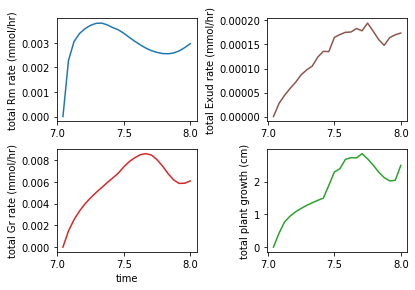

In [29]:


fig, axs = plt.subplots(2,2)
axs[0,0].plot(time, Q_Rmall)
axs[0,0].set(xlabel='', ylabel='total Rm rate (mmol/hr)')
axs[1,0].plot(time, Q_Grall, 'tab:red')
axs[1,0].set(xlabel='time', ylabel='total Gr rate (mmol/hr)')
axs[0,1].plot(time, Q_Exudall , 'tab:brown')
axs[0,1].set(xlabel='', ylabel='total Exud rate (mmol/hr)')
axs[1,1].plot(time, Growthall , 'tab:green')
axs[1,1].set(xlabel='', ylabel='total plant growth (cm)')
fig.tight_layout()
plt.show()

## Take away messages

* Basic idea how to use the class *PhloemFlow*
* The plant growth follows the rate of carbon usage for growth